In [5]:
import tensorflow as tf
import zipfile
import os
import shutil

In [22]:
img_size = (150, 150)
batch_size = 32

extract_dir = "cat_dog_data"
if os.path.exists(extract_dir):
    shutil.rmtree(extract_dir)
os.makedirs(extract_dir)

train_dir = os.path.join(extract_dir, "train")
val_dir = os.path.join(extract_dir, "validation")
os.makedirs(os.path.join(train_dir, "cats"))
os.makedirs(os.path.join(train_dir, "dogs"))
os.makedirs(os.path.join(val_dir, "cats"))
os.makedirs(os.path.join(val_dir, "dogs"))

with zipfile.ZipFile("cat_dog-train.zip", "r") as z:
    all_files = z.namelist()

    for i, name in enumerate(all_files):
        fname = name.split("/")[-1]
        if fname.startswith("cat."):
            category = "cats"
        elif fname.startswith("dog."):
            category = "dogs"
        else:
            continue

        target_dir = train_dir if i % 5 != 0 else val_dir

        with z.open(name) as source:
            target_path = os.path.join(target_dir, category, fname)
            with open(target_path, 'wb') as target:
                target.write(source.read())

In [6]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary' # or 'categorical' for more than 2 labels
)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [16]:
def make_cnn_small_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(150, 150, 3)),
        tf.keras.layers.Conv2D(32, (3, 3), activation=tf.nn.relu, padding='same'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation=tf.nn.relu, padding='same'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
    ])
    model.compile(optimizer=tf.optimizers.Adam(), loss=tf.losses.binary_crossentropy, metrics=[tf.metrics.binary_accuracy])
    return model

In [15]:
def make_cnn_big_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(150, 150, 3)),
        tf.keras.layers.Conv2D(32, (3, 3), activation=tf.nn.relu, padding='same'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation=tf.nn.relu, padding='same'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation=tf.nn.relu, padding='same'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(256, (3, 3), activation=tf.nn.relu, padding='same'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1, activation=tf.nn.sigmoid) # instead of softmax since its a binary output
    ])
    model.compile(optimizer=tf.optimizers.Adam(), loss=tf.losses.binary_crossentropy, metrics=[tf.metrics.binary_accuracy])
    return model

In [9]:
def train(models: list[tf.keras.Model], train_gen, val_gen, epochs=5):
    histories = []
    for model in models:
        history = model.fit(
            train_gen,
            epochs=epochs,
            validation_data=val_gen,
            steps_per_epoch=train_gen.samples // train_gen.batch_size,
            validation_steps=val_gen.samples // val_gen.batch_size
        )
        histories.append(history)
    return histories

In [10]:
def save(models: list[tf.keras.Model]):
    for i in range(len(models)):
        models[i].save(f"model-{i}.keras")

In [11]:
from matplotlib import pyplot as plt
from typing import Any, List, Dict, Union, Optional

HistoryLike = Union[Dict[str, List[float]], Any]


def _detect_accuracy_keys(history: Dict[str, List[float]]):
    candidate_val = next((k for k in history.keys() if k.startswith('val_') and ('acc' in k or 'accuracy' in k)), None)
    if candidate_val:
        train_key = candidate_val[len('val_'):]
        val_key = candidate_val
        if train_key not in history:
            train_key = next((k for k in history.keys() if ('acc' in k or 'accuracy' in k) and not k.startswith('val_')), None)
    else:
        train_key = next((k for k in history.keys() if ('acc' in k or 'accuracy' in k) and not k.startswith('val_')), None)
        val_key = ('val_' + train_key) if train_key and ('val_' + train_key) in history else None
        if not val_key:
            val_key = next((k for k in history.keys() if k.startswith('val_') and ('acc' in k or 'accuracy' in k)), None)
    return train_key, val_key


def plot_histories(histories: list[HistoryLike],
                    model_names: Optional[List[str]] = None,
                    show_train: bool = True,
                    show_val: bool = True,
                    figsize=(10, 6)):
    dicts = []
    for h in histories:
        if hasattr(h, "history"):
            dicts.append(h.history)
        elif isinstance(h, dict):
            dicts.append(h)
        else:
            raise TypeError(f"Unsupported history type: {type(h)}")

    if model_names is None:
        model_names = [f"model-{i}" for i in range(len(dicts))]
    if len(model_names) != len(dicts):
        raise ValueError("`model_names` length must match number of histories.")

    fig, ax = plt.subplots(figsize=figsize)
    for i, hist in enumerate(dicts):
        train_key, val_key = _detect_accuracy_keys(hist)
        name = model_names[i]
        epochs = range(1, max((len(v) for v in hist.values()), default=0) + 1)
        if show_train and train_key and train_key in hist:
            ax.plot(range(1, len(hist[train_key]) + 1), hist[train_key],
                    label=f"{name} train ({train_key})", linestyle='-', marker=None)
        if show_val and val_key and val_key in hist:
            ax.plot(range(1, len(hist[val_key]) + 1), hist[val_key],
                    label=f"{name} val ({val_key})", linestyle='--', marker=None)

    ax.set_xlabel("Epoch")
    ax.set_ylabel("Accuracy")
    ax.set_title("Training and Validation Accuracy")
    ax.grid(True, linestyle=':', linewidth=0.5)
    ax.legend(loc='best', fontsize='small')
    plt.tight_layout()
    return fig, ax


In [18]:
models = [make_cnn_small_model(), make_cnn_big_model()]

In [19]:
output = train(models, train_generator, validation_generator)

Epoch 1/5


2025-12-09 12:31:38.176301: I external/local_xla/xla/service/service.cc:163] XLA service 0x7f1f8c016960 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-09 12:31:38.176315: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2025-12-09 12:31:38.206548: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-09 12:31:38.347414: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91300


  6/625 ━━━━━━━━━━━━━━━━━━━━ 19s 32ms/step - binary_accuracy: 0.4787 - loss: 0.8836

I0000 00:00:1765279901.403061  522093 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


625/625 ━━━━━━━━━━━━━━━━━━━━ 26s 36ms/step - binary_accuracy: 0.6585 - loss: 0.6132 - val_binary_accuracy: 0.7292 - val_loss: 0.5491
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - binary_accuracy: 0.7468 - loss: 0.5145 - val_binary_accuracy: 0.7570 - val_loss: 0.5029
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - binary_accuracy: 0.7890 - loss: 0.4594 - val_binary_accuracy: 0.7790 - val_loss: 0.4738
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - binary_accuracy: 0.8117 - loss: 0.4109 - val_binary_accuracy: 0.7776 - val_loss: 0.4722
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - binary_accuracy: 0.8415 - loss: 0.3555 - val_binary_accuracy: 0.7891 - val_loss: 0.4701
Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 29s 41ms/step - binary_accuracy: 0.6686 - loss: 0.5987 - val_binary_accuracy: 0.7712 - val_loss: 0.4807
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 26s 42ms/step - binary_accuracy: 0.7794 - loss: 0.4655 - val_binary_accuracy: 0.8107 - val_loss: 0.4120
Epoch 3/5

In [20]:
save(models)

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Training and Validation Accuracy'}, xlabel='Epoch', ylabel='Accuracy'>)

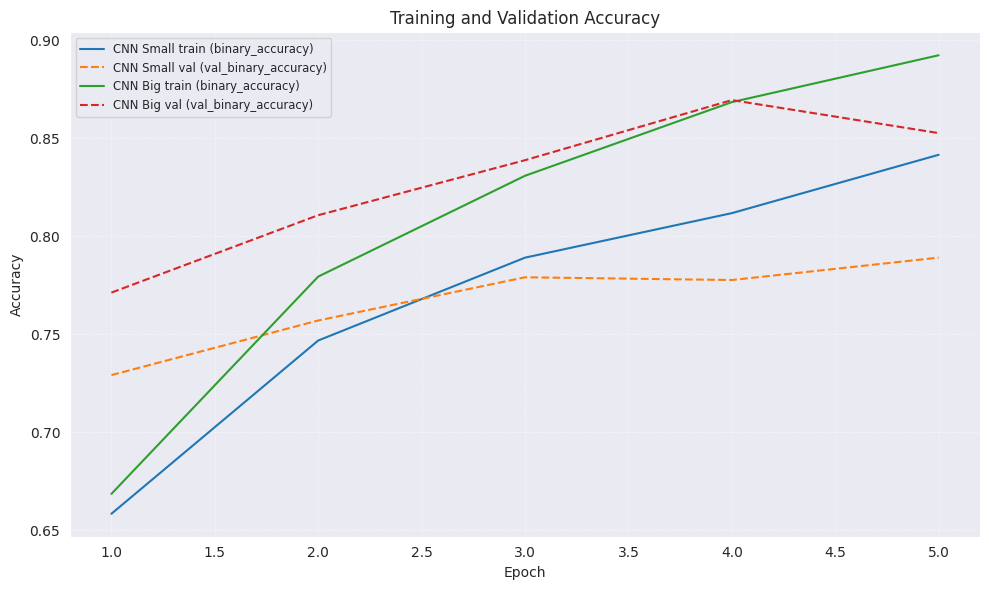

In [21]:
plot_histories(output, ["CNN Small", "CNN Big"])